# Devanagri Script Character Recognition using Convolutional Neural Networks:

Devanagari is an Indic script. It consists of 47 primary alphabets, 14 vowels, and 33 consonants, and 10 digits.

__About the data (Extracted Images):__

The dataset consists of 92000 rows (sample greyscale images) of size (32 x 32), and 1025 columns. Each row contains the pixel data ("pixel0000" to "pixel1023"), in greyscale values (0 to 255). The column _character_ represents the Devanagari character name corresponding to each image.


Refer for dataset:

https://www.kaggle.com/rishianand/devanagari-character-set/data


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tf.__version__

'2.0.0'

### Data preprocessing steps:

In [3]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 32, 32

In [4]:
# Read-in CSV file containing 92,000 images-
data = pd.read_csv("devanagri_data.csv")

In [5]:
# Get shape/dimension of dataset-
data.shape

(92000, 1025)

In [6]:
# Target attribute is 'character'-
'character' in data.columns

True

In [7]:
# Split dataset into features (X) and target (y)-
X = data.drop('character', axis = 1)
y = data['character']

In [8]:
# Convert to numpy arrays-
X = X.values
y = y.values

In [9]:
X.shape, y.shape

((92000, 1024), (92000,))

In [10]:
# Check distribution of target attribute-
data['character'].value_counts()

character_12_thaa            2000
digit_7                      2000
character_01_ka              2000
character_23_ba              2000
character_04_gha             2000
character_27_ra              2000
character_25_ma              2000
character_17_tha             2000
digit_8                      2000
character_13_daa             2000
character_32_patalosaw       2000
character_29_waw             2000
digit_3                      2000
digit_1                      2000
character_10_yna             2000
digit_6                      2000
character_21_pa              2000
character_35_tra             2000
character_02_kha             2000
character_33_ha              2000
character_36_gya             2000
character_34_chhya           2000
character_24_bha             2000
character_09_jha             2000
character_19_dha             2000
character_07_chha            2000
character_08_ja              2000
character_31_petchiryakha    2000
digit_9                      2000
character_06_c

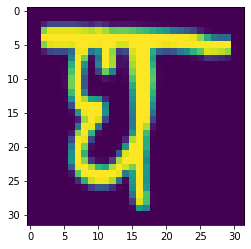

In [16]:
# Visualize a character from dataset-
plt.imshow(X[6000, :].reshape(32, 32))
plt.show()

In [17]:
# Reshape data for CNN-
X_exp = X.reshape(X.shape[0], 32, 32, 1)
X_exp.shape

(92000, 32, 32, 1)

In [18]:
# Label encode target attribute-

# Initialize a label encoder-
le = LabelEncoder()

# Train label encoder on target attribute-
y_transformed = le.fit_transform(y)

# To get back original target-
# y_orig = le.inverse_transform(y_transformed)

In [19]:
# number of classes for target attribute-
print("number of classes for target attribute = {0}".format(len(set(y))))

number of classes for target attribute = 46


In [20]:
batch_size = 60
num_classes = len(set(y))
num_epochs = 100

In [21]:
# Split features and target attribute into training and testing sets-
# X_train, X_test, y_train, y_test = train_test_split(data.drop('character',axis=1), y, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_transformed, test_size=0.3)

In [22]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [23]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [24]:
print("\nShapes of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}\n".format(X_test.shape, y_test.shape))


Shapes of training and testing sets are:
X_train.shape = (64400, 32, 32, 1), y_train = (64400, 46)
X_test.shape = (27600, 32, 32, 1), y_test = (27600, 46)



### Prepare MNIST dataset for _GradientTape_ training:

In [25]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [26]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [27]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [28]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.0012)


In [29]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')


In [30]:
# The model is first trained without any pruning for 'num_epochs' epochs-
epochs = num_epochs

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  107400


In [31]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [32]:
l = tf.keras.layers

In [42]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following LeNet-5 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 6, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid',
            input_shape=(32, 32, 1)
        ),
        **pruning_params_conv)
    )
       
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 16, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'valid'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
   
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 120, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 84, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = num_classes, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model

In [40]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [44]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

In [45]:
# Save weights for later-
orig_model.save_weights("LeNet_5_Devanagri_Random_Weights.h5", overwrite=True)

In [46]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [47]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

### Train defined CNN to get baseline performance:

In [48]:
# Sanity check: Whether defined CNN works as intended-

history = orig_model.fit(
    x = X_train, y = y_train,
    epochs=num_epochs, batch_size=batch_size,
    verbose=1, shuffle=True,
    callbacks=callback,
    validation_data=(X_test, y_test)
)


Epoch 1/100
1074/1074 [==============================] - 24s 22ms/step - loss: 0.9261 - accuracy: 0.7395 - val_loss: 0.4182 - val_accuracy: 0.8758
Epoch 2/100
1074/1074 [==============================] - 23s 21ms/step - loss: 0.3104 - accuracy: 0.9062 - val_loss: 0.3143 - val_accuracy: 0.9057
Epoch 3/100
1074/1074 [==============================] - 23s 21ms/step - loss: 0.2087 - accuracy: 0.9358 - val_loss: 0.2138 - val_accuracy: 0.9371
Epoch 4/100
1074/1074 [==============================] - 23s 21ms/step - loss: 0.1570 - accuracy: 0.9503 - val_loss: 0.1944 - val_accuracy: 0.9429
Epoch 5/100
1074/1074 [==============================] - 23s 22ms/step - loss: 0.1234 - accuracy: 0.9613 - val_loss: 0.2037 - val_accuracy: 0.9404
Epoch 6/100
1074/1074 [==============================] - 23s 22ms/step - loss: 0.1044 - accuracy: 0.9661 - val_loss: 0.1692 - val_accuracy: 0.9521
Epoch 7/100
1074/1074 [==============================] - 25s 23ms/step - loss: 0.0845 - accuracy: 0.9714 - val_loss: 0

In [51]:
# Trained CNN performance on validation data set-
model_val_loss, model_val_acc = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nTrained LeNet-5 CNN model metrics on validation set:")
print("val_loss = {0:.5f} and val_accuracy = {1:.5f}%\n".format(
    model_val_loss, model_val_acc * 100
))


Trained LeNet-5 CNN model metrics on validation set:
val_loss = 0.17512 and val_accuracy = 95.48913%



### Question:

Can the model's performance be further improved?

To tackle this question, the following Convolutional Neural Networks are experimented with:

1. Conv-2
1. Conv-4
1. Conv-6

These CNNs are _VGG-16_ inspired. VGG-16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

Originally, these CNNs were designed for _CIFAR-10_ dataset. But for our experiment, these CNNs will be used for the _Devanagri_ dataset.

In [42]:
def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-2 architecture-
    64, 64, pool  -- convolutions
    256, 256, 46  -- fully connected layers
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 1)
        ),
        **pruning_params_conv)
    )
        
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = num_classes, activation='softmax'
        ),
        **pruning_params_fc)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model

In [43]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)

In [44]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [45]:
# Save random weights-
orig_model.save_weights("Conv_2_Devanagri_Random_Weights.h5", overwrite=True)

In [46]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 46)               

In [47]:
# Sanity check: Whether defined CNN works as intended-

history_conv2 = orig_model.fit(
    x = X_train, y = y_train,
    epochs=num_epochs, batch_size=batch_size,
    verbose=1, shuffle=True,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

Train on 64400 samples, validate on 27600 samples
Epoch 1/100
64400/64400 [==============================] - 116s 2ms/sample - loss: 0.4587 - accuracy: 0.8674 - val_loss: 0.1825 - val_accuracy: 0.9445
Epoch 2/100
64400/64400 [==============================] - 114s 2ms/sample - loss: 0.1108 - accuracy: 0.9649 - val_loss: 0.1460 - val_accuracy: 0.9560
Epoch 3/100
64400/64400 [==============================] - 114s 2ms/sample - loss: 0.0592 - accuracy: 0.9806 - val_loss: 0.1244 - val_accuracy: 0.9639
Epoch 4/100
64400/64400 [==============================] - 114s 2ms/sample - loss: 0.0432 - accuracy: 0.9858 - val_loss: 0.1343 - val_accuracy: 0.9645
Epoch 5/100
64400/64400 [==============================] - 114s 2ms/sample - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.1029 - val_accuracy: 0.9727
Epoch 6/100
64400/64400 [==============================] - 114s 2ms/sample - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.1299 - val_accuracy: 0.9678
Epoch 7/100
64400/64400 [===================

In [48]:
# Trained CNN performance on validation data set-
model_val_loss, model_val_acc = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nTrained Conv-2 CNN model metrics on validation set:")
print("val_loss = {0:.5f} and val_accuracy = {1:.5f}%\n".format(
    model_val_loss, model_val_acc * 100
))


Trained Conv-2 CNN model metrics on validation set:
val_loss = 0.11955 and val_accuracy = 97.36956%



In [49]:
def pruned_nn(pruning_params_conv, pruning_params_fc, pruning_params_op):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-4 architecture-
    64, 64, pool  -- convolutions
    128, 128, pool -- convolutions
    256, 256, 46  -- fully connected layers
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 1)
        ),
        **pruning_params_conv)
    )
        
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = num_classes, activation='softmax'
        ),
        **pruning_params_op)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model


In [50]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned, pruning_params_unpruned)

In [51]:
# Strip model of it's pruning parameters
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [52]:
# Save random weights-
orig_model.save_weights("Conv_4_Devanagri_Random_Weights.h5", overwrite=True)

In [53]:
# Get CNN summary-
orig_model_stripped.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [54]:
# Sanity check: Whether defined CNN works as intended-

history_conv4 = orig_model.fit(
    x = X_train, y = y_train,
    epochs=num_epochs, batch_size=batch_size,
    verbose=1, shuffle=True,
    callbacks=callback,
    validation_data=(X_test, y_test)
)



Train on 64400 samples, validate on 27600 samples
Epoch 1/100
64400/64400 [==============================] - 170s 3ms/sample - loss: 0.4297 - accuracy: 0.8769 - val_loss: 0.1237 - val_accuracy: 0.9615
Epoch 2/100
64400/64400 [==============================] - 167s 3ms/sample - loss: 0.0885 - accuracy: 0.9728 - val_loss: 0.0868 - val_accuracy: 0.9750
Epoch 3/100
64400/64400 [==============================] - 168s 3ms/sample - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.0734 - val_accuracy: 0.9790
Epoch 4/100
64400/64400 [==============================] - 168s 3ms/sample - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0951 - val_accuracy: 0.9748
Epoch 5/100
64400/64400 [==============================] - 168s 3ms/sample - loss: 0.0351 - accuracy: 0.9892 - val_loss: 0.0672 - val_accuracy: 0.9814
Epoch 6/100
64400/64400 [==============================] - 168s 3ms/sample - loss: 0.0301 - accuracy: 0.9905 - val_loss: 0.0667 - val_accuracy: 0.9813
Epoch 7/100
64400/64400 [===================

In [55]:
# Trained CNN performance on validation data set-
model_val_loss, model_val_acc = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nTrained Conv-4 CNN model metrics on validation set:")
print("val_loss = {0:.5f} and val_accuracy = {1:.5f}%\n".format(
    model_val_loss, model_val_acc * 100
))


Trained Conv-4 CNN model metrics on validation set:
val_loss = 0.08423 and val_accuracy = 98.13043%



In [57]:
def pruned_nn(pruning_params_conv, pruning_params_fc, pruning_params_op):
    """
    Function to define the architecture of a neural network model
    following Conv-6 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-6 architecture-
    64, 64, pool  -- convolutional layers
    128, 128, pool -- convolutional layers
    256, 256, pool -- convolutional layers
    256, 256, 46  -- fully connected layers
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 1)
        ),
        **pruning_params_conv)
    )
        
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        ),
        **pruning_params_conv)
    )

    pruned_model.add(sparsity.prune_low_magnitude(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        ),
        **pruning_params_conv)
    )
    
    pruned_model.add(Flatten())
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        ),
        **pruning_params_fc)
    )
    
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(
            units = num_classes, activation='softmax'
        ),
        **pruning_params_op)
    )
    

    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.0012),
        metrics=['accuracy']
    )
    
    
    return pruned_model


In [58]:
# Initialize a CNN model-
orig_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned, pruning_params_unpruned)

In [59]:
# Strip model of it's pruning parameters-
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [60]:
# Save random weights-
orig_model.save_weights("Conv_6_Devanagri_Random_Weights.h5", overwrite=True)

In [61]:
# Get defined CNN summary-
orig_model_stripped.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)        

In [62]:
# Sanity check: Whether defined CNN works as intended-

history_conv6 = orig_model.fit(
    x = X_train, y = y_train,
    epochs=num_epochs, batch_size=batch_size,
    verbose=1, shuffle=True,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

Train on 64400 samples, validate on 27600 samples
Epoch 1/100
64400/64400 [==============================] - 225s 3ms/sample - loss: 0.7001 - accuracy: 0.8025 - val_loss: 0.1675 - val_accuracy: 0.9474
Epoch 2/100
64400/64400 [==============================] - 222s 3ms/sample - loss: 0.1062 - accuracy: 0.9667 - val_loss: 0.0796 - val_accuracy: 0.9776
Epoch 3/100
64400/64400 [==============================] - 222s 3ms/sample - loss: 0.0651 - accuracy: 0.9798 - val_loss: 0.1002 - val_accuracy: 0.9702
Epoch 4/100
64400/64400 [==============================] - 222s 3ms/sample - loss: 0.0545 - accuracy: 0.9830 - val_loss: 0.0731 - val_accuracy: 0.9788
Epoch 5/100
64400/64400 [==============================] - 223s 3ms/sample - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.0696 - val_accuracy: 0.9796
Epoch 6/100
64400/64400 [==============================] - 223s 3ms/sample - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0677 - val_accuracy: 0.9801
Epoch 7/100
64400/64400 [===================

In [63]:
# Trained CNN performance on validation data set-
model_val_loss, model_val_acc = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nTrained Conv-6 CNN model metrics on validation set:")
print("val_loss = {0:.5f} and val_accuracy = {1:.5f}%\n".format(
    model_val_loss, model_val_acc * 100
))


Trained Conv-6 CNN model metrics on validation set:
val_loss = 0.06914 and val_accuracy = 98.55072%



### Conclusion:

It seems that _Conv-6_ Convolutional Neural Network (CNN) has the 'best' validation accuracy for the _Devanagri_ dataset. Therefore, _Conv-6_ CNN will be used for 'The Lottery Ticket Hypothesis'.